In [1]:
import os
import glob
import time

import numpy as np
import pandas as pd
#IPython.display for audio output
import IPython.display as ipd
# Librosa for audio
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# For designing the band-pass filter
from scipy.signal import butter, lfilter, hilbert

import matplotlib.pyplot as plt
import matplotlib.style as ms
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def butter_bandpass_filter(data, lowcut=500, highcut=1500, fs=8000, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

### Use librosa.load to load audio time series data

In [4]:
fn = '/home/xukecheng/Desktop/cleaned_data/train_balanced/Emergency/101.wav'
y, sr = librosa.load(fn, sr=8000)
ipd.Audio(fn)

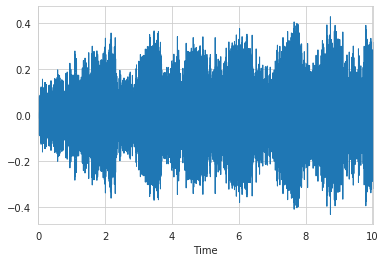

In [5]:
librosa.display.waveplot(y=y, sr=sr);

In [6]:
print(y.shape)

(80214,)


### Apply butter bandpass filter on audio time series data

In [7]:
y_filt = butter_bandpass_filter(y)
print(y_filt.shape)

(80214,)


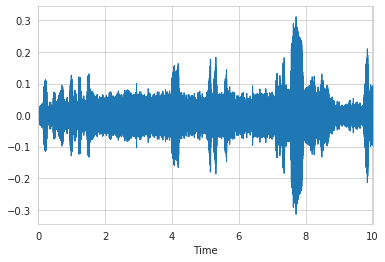

In [8]:
librosa.display.waveplot(y=y_filt, sr=sr)

In [9]:
def melspectrogram(y,sr):
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    
    return log_S

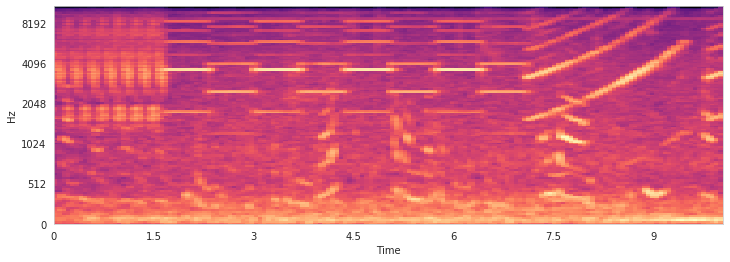

In [10]:
log_S = melspectrogram(y,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');

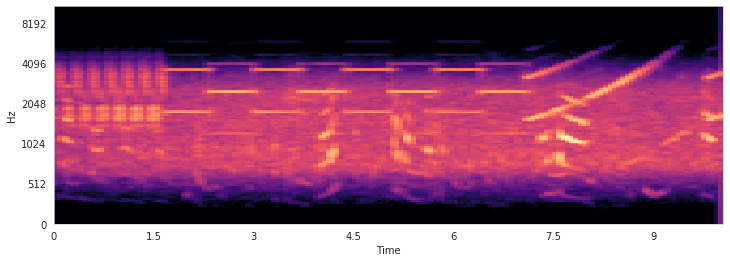

In [11]:
log_S = melspectrogram(y_filt,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');

In [12]:
print(log_S.shape)

(128, 157)


In [13]:
analytic_signal = hilbert(y_filt)
amplitude_envelope = np.abs(analytic_signal)

/home/xukecheng/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


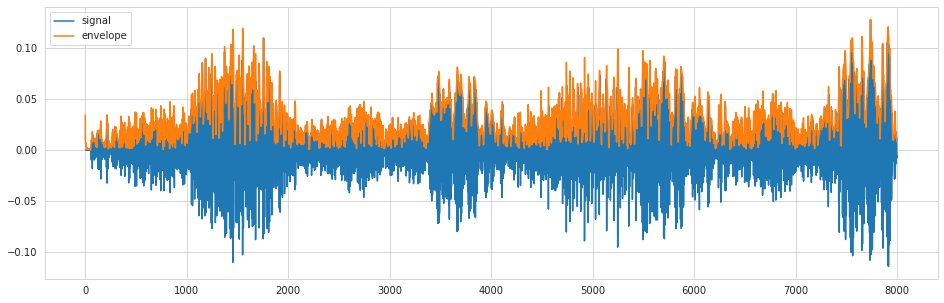

In [14]:
t = np.arange(len(y[:8000])) / sr
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_subplot(111)
# ax0.plot(y[:8000], label='signal')
ax0.plot(analytic_signal[:8000], label='signal')
ax0.plot(amplitude_envelope[:8000], label='envelope')
ax0.legend();

## Feature Extraction

In [15]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

In [16]:
def preprocess(y):
    y_filt = butter_bandpass_filter(y)
    analytic_signal = hilbert(y_filt)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

In [17]:
# Read all the files from the dataset folder
# HEADS UP: update the paths according to your local machine
path_em = '/home/xukecheng/Desktop/cleaned_data/train_balanced/Emergency/'
path_nonem = '/home/xukecheng/Desktop/cleaned_data/train_balanced/nonEmergency/'

em_files = glob.glob(os.path.join(path_em, '*.wav'))
nonem_files = glob.glob(os.path.join(path_nonem, '*.wav'))

In [18]:
X_em = []
for fn in tqdm(em_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    X_em.extend(features)

100%|██████████| 123/123 [02:25<00:00,  1.18s/it]


In [19]:
len(X_em)

20924

In [20]:
len(X_em[0])

34

In [21]:
count = 0
X_nonem = []
for fn in tqdm(nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_nonem.extend(features)
    count += 1
    if count == 120:
        break

  7%|▋         | 119/1667 [03:04<26:11,  1.02s/it]  

In [22]:
len(X_nonem)

23061

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def prepare_data(X_em, X_nonem):
    X_em = np.array(X_em)
    X_nonem = np.array(X_nonem)
    
    X = np.vstack((X_em, X_nonem))
    Y = np.hstack((np.ones(len(X_em)), np.zeros(len(X_nonem))))
    
    scaler = StandardScaler()
    scaler.fit_transform(X)
    
    X, Y = shuffle(X, Y, random_state=7)
    
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return X, Y, scaler

In [24]:
X_train, Y_train, scaler1 = prepare_data(X_em, X_nonem)

In [25]:
f= open("scaler_values.txt","w+")
mean_v = []
std_v = []
for i in range(len(scaler1.mean_)):
    mean_v.append(scaler1.mean_[i])
    std_v.append(scaler1.scale_[i])
f.write("scaler mean:\n{}".format(mean_v))
f.write("\nscaler std:\n{}".format(std_v))
f.close()

In [26]:
# HEADS UP: update the paths according to your local machine
test_path_em = '/home/xukecheng/Desktop/cleaned_data/eval_balanced/Emergency/'
test_path_nonem = '/home/xukecheng/Desktop/cleaned_data/eval_balanced/nonEmergency/'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

In [27]:
X_test_em = []
for fn in tqdm(test_em_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_test_em.extend(features)


100%|██████████| 134/134 [02:35<00:00,  1.16s/it]


In [28]:
X_test_nonem = []
for fn in tqdm(test_nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_test_nonem.extend(features)


100%|██████████| 105/105 [02:09<00:00,  1.23s/it]


In [29]:
X_test, Y_test, scaler2 = prepare_data(X_test_em, X_test_nonem)

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras import optimizers
import tensorflow as tf
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
np.random.seed(7)

# Supress Tensorflow error logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.


In [31]:
model = Sequential()
model.add(Dense(34, input_dim=34, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0912 17:26:32.366890 140650137638720 deprecation_wrapper.py:119] From /home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 17:26:32.371330 140650137638720 deprecation_wrapper.py:119] From /home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 17:26:32.377359 140650137638720 deprecation_wrapper.py:119] From /home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 34)                1190      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2240      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 45,031
Trainable params: 45,031
Non-trainable params: 0
_________________________________________________________________


In [32]:
optm = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=0, mode='auto')
callbacks_list = [earlystop]

W0912 17:26:37.652541 140650137638720 deprecation_wrapper.py:119] From /home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0912 17:26:37.659629 140650137638720 deprecation_wrapper.py:119] From /home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0912 17:26:37.666034 140650137638720 deprecation.py:323] From /home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
history = model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=256, callbacks=callbacks_list)
model.save("model_3h.h5")
print("Saved model to disk!")

W0912 17:26:43.705062 140650137638720 deprecation_wrapper.py:119] From /home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 43985 samples, validate on 42101 samples
Epoch 1/200
43985/43985 [==============================] - 3s 73us/step - loss: 0.5631 - acc: 0.7032 - val_loss: 0.5726 - val_acc: 0.7035
Epoch 2/200
43985/43985 [==============================] - 1s 32us/step - loss: 0.4635 - acc: 0.7900 - val_loss: 0.5246 - val_acc: 0.7540
Epoch 3/200
43985/43985 [==============================] - 1s 32us/step - loss: 0.4345 - acc: 0.8072 - val_loss: 0.4847 - val_acc: 0.7781
Epoch 4/200
43985/43985 [==============================] - 1s 33us/step - loss: 0.4080 - acc: 0.8212 - val_loss: 0.4690 - val_acc: 0.7869
Epoch 5/200
43985/43985 [==============================] - 1s 32us/step - loss: 0.3925 - acc: 0.8308 - val_loss: 0.5011 - val_acc: 0.7769
Epoch 6/200
43985/43985 [==============================] - 1s 33us/step - loss: 0.3871 - acc: 0.8341 - val_loss: 0.4739 - val_acc: 0.7880
Epoch 7/200
43985/43985 [==============================] - 1s 31us/step - loss: 0.3784 - acc: 0.8376 - val_loss: 0.4880 - 

In [34]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('model_history.png')

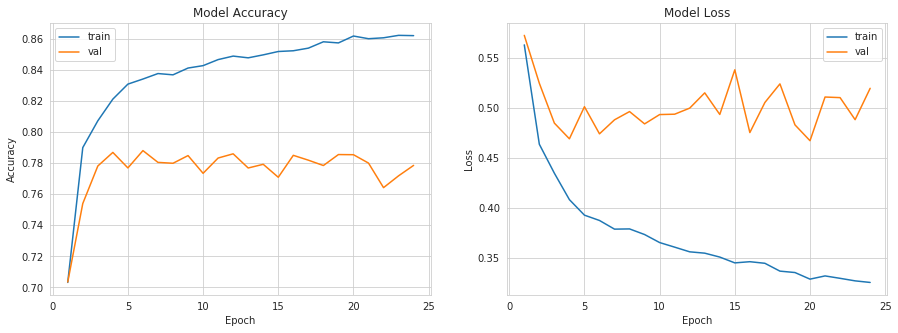

In [35]:
plot_model_history(history)

In [36]:
model = load_model('model_3h.h5')

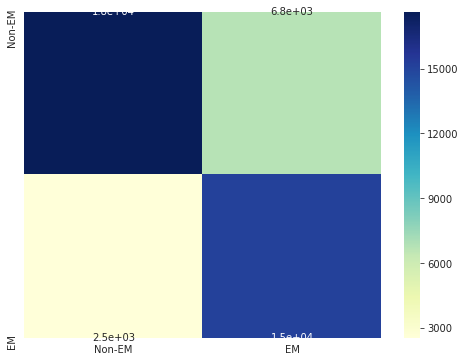

In [37]:
Y_pred = model.predict_classes(X_test)
cm = confusion_matrix(Y_pred, Y_test)
df_cm = pd.DataFrame(cm, index = ['Non-EM', 'EM'],
                  columns = ['Non-EM', 'EM'])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, cmap='YlGnBu');

In [38]:
def predict_op(y, scaler):
    y = preprocess(y)
    features_list = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    scaler.transform(features_list)
    count = 0
    N = 10
    th = 0.5
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(features_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(features_list)):
        prob_list.pop(0)
        p = model.predict(features_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    if np.mean(class_list) > 0.5:
        return 1
    else:
        return 0

In [39]:
# HEADS UP: update the paths according to your local machine
test_path_em = '/home/xukecheng/Desktop/cleaned_data/eval_balanced/Emergency/'
test_path_nonem = '/home/xukecheng/Desktop/cleaned_data/eval_balanced/nonEmergency/'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

tot = 0
correct_em = 0
op_list = []
for test_file in tqdm(test_em_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 1:
        correct_em += 1
    tot += 1


100%|██████████| 134/134 [02:56<00:00,  1.32s/it]


In [40]:
correct_em

106

In [41]:
tot

134

In [42]:
tot = 0
correct_nonem = 0
op_list = []
for test_file in tqdm(test_nonem_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 0:
        correct_nonem += 1
    tot += 1


100%|██████████| 105/105 [02:26<00:00,  1.40s/it]


In [43]:
tot

105

In [44]:
correct_nonem

101

In [45]:
# HEADS UP: update the path according to your local machine
test_file = '/home/xukecheng/Desktop/cleaned_data/eval_balanced/Emergency/101.wav'
y, sr = librosa.load(test_file, sr=8000)
ipd.Audio(test_file)

FP: 104 (bicycle bell)  
FN: 12 (clear siren), 15 (vehicle noise)

In [46]:
def predict_prob(y, scaler):
    y = preprocess(y)
    mfccs_list = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    scaler.transform(mfccs_list)
    count = 0
    N = 20
    th = 0.5
    
    model = load_model('model_3h.h5')
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(mfccs_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(mfccs_list)):
        prob_list.pop(0)
        p = model.predict(mfccs_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    return class_list

In [47]:
classes = predict_prob(y, scaler2)

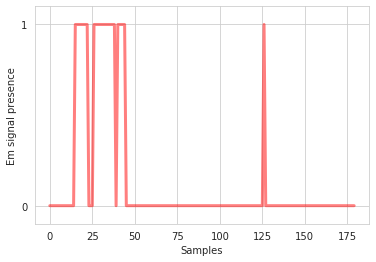

In [48]:
plt.figure()
plt.plot(classes, c='r', linewidth = 3.0, alpha=0.5)
plt.yticks([0,1])
plt.ylim([-0.1,1.1])
plt.xlabel("Samples")
plt.ylabel("Em signal presence")
plt.grid('on')
plt.show()

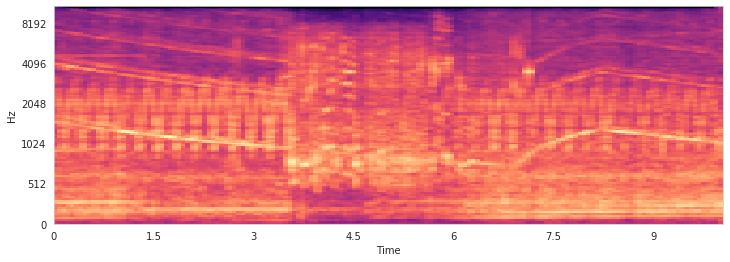

In [49]:
log_S = melspectrogram(y,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');